# Final figure for the paper

In [1]:
# packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os

from mtist import mtist_utils as mu
from mtist import infer_mtist as im
calculate_es_score = im.calculate_es_score

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# get calculated scores for linear regression, and its regularized versions (with cross-validation), for geometric averaging

geom_lr_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_geom_mean/es_scores.csv", index_col=0)
geom_lasso_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_lasso_cv_geom_mean/es_scores.csv", index_col=0)
geom_ridge_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_ridge_cv_geom_mean/es_scores.csv", index_col=0)
geom_elasticnet_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_elasticnet_cv_geom_mean/es_scores.csv", index_col=0)

In [3]:
# get number of species of each dataset and add it to score dataframes

n_sp = []
for i in range(len(geom_lr_scores)):
    n_sp.append(open(f"mtist_datasets/dataset_{i}.csv", "r").readlines()[0].count("species_"))

geom_lr_scores["n_sp"] = n_sp
geom_lasso_scores["n_sp"] = n_sp
geom_ridge_scores["n_sp"] = n_sp
geom_elasticnet_scores["n_sp"] = n_sp

## Generate null model inferred_aij's

In [4]:
# create folder for results

try:
    os.mkdir("mtist_datasets/output_geom/inference_result_random_geom_mean")
except:
    print("Folder already exists: mtist_datasets/output_geom/inference_result_random_geom_mean")
    pass

Folder already exists: mtist_datasets/output_geom/inference_result_random_geom_mean


In [5]:
# generate random inferred_aij's

np.random.seed(0)

for i in tqdm(range(len(n_sp))):
    inferred_aij = np.random.normal(size=(n_sp[i], n_sp[i]))
    np.savetxt(f"mtist_datasets/output_geom/inference_result_random_geom_mean/inferred_aij_{i}.csv", inferred_aij, delimiter=",")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:03<00:00, 352.27it/s]


### Score null model inferred_aij's

In [6]:
# INFERENCE_DEFAULTS class to use in adapted infer_and_score_all function, to test new ES score

class INFERENCE_DEFAULTS:

    # Set INFERENCE_FUNCTION to a handle that takes did and spits out
    # an inferred Aij

    # If changing the inference function and wish to save the result,
    # change the inference prefix (end it in like a _ or something)
    INFERENCE_FUNCTION = "random"
    INFERENCE_PREFIX = ""

    inference_threshold = 1 / 3

In [7]:
# adapted infer_and_score_all to score with new ES score

def score_all(save_scores=True, mean="geom"):
    # Load meta and gts
    meta = pd.read_csv(os.path.join(mu.GLOBALS.MTIST_DATASET_DIR, "mtist_metadata.csv")).set_index(
        "did"
    )
    aijs, _ = mu.load_ground_truths(mu.GLOBALS.GT_DIR)

    n_datasets = mu.calculate_n_datasets()
    fns = [
        os.path.join(mu.GLOBALS.MTIST_DATASET_DIR, f"dataset_{i}.csv") for i in range(n_datasets)
    ]

    th = INFERENCE_DEFAULTS.inference_threshold  # for the floored_scores
    raw_scores = {}
    floored_scores = {}
    inferred_aijs = {}

    for i in tqdm(range(len(fns))):

        # Complete the inference
        did = int(fns[i].split(".csv")[0].split("dataset_")[-1])
        
        inferred_aij = np.loadtxt(f"{mu.GLOBALS.MTIST_DATASET_DIR}/output_geom/inference_result_{INFERENCE_DEFAULTS.INFERENCE_FUNCTION}_{mean}_mean/inferred_aij_{did}.csv", delimiter=",")
        
        # Obtain gt used in the dataset
        gt_used = meta.loc[did, "ground_truth"]
        true_aij = aijs[gt_used]
        
        # Calculate raw ES score
        es_score = calculate_es_score(true_aij, inferred_aij)

        # Calculate floored ES score
        floored_inferred_aij = inferred_aij.copy()  # copy aij
        mask = np.abs(floored_inferred_aij) < th  # determine where to floor
        floored_inferred_aij[mask] = 0  # floor below the th
        es_score_floored = calculate_es_score(true_aij, floored_inferred_aij)

        # Save the scores
        raw_scores[did] = es_score
        floored_scores[did] = es_score_floored

    df_es_scores = pd.DataFrame(
        [raw_scores, floored_scores], index=["raw", "floored"]
    ).T.sort_index()

    if save_scores:
        df_es_scores.to_csv(
            os.path.join(
                mu.GLOBALS.MTIST_DATASET_DIR,
                "output_geom",
                f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}inference_result"+\
                f"_{INFERENCE_DEFAULTS.INFERENCE_FUNCTION}_{mean}_mean",
                f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}es_scores.csv",
            )
        )

In [8]:
# score null model inferred_aij's

score_all()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:14<00:00, 76.71it/s]


In [9]:
# read scores and add number of species to its dataframe

geom_random_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_random_geom_mean/es_scores.csv", index_col=0)
geom_random_scores["n_sp"] = n_sp

---
## Null model with variable zero interation probability

In [52]:
p0_list = [0.0, 0.5, 0.9]

In [53]:
# create folder for results

for p0 in p0_list:
    try:
        os.mkdir(f"mtist_datasets/output_geom/inference_result_random_p(0)={p0}_geom_mean")
    except:
        print(f"Folder already exists: mtist_datasets/output_geom/inference_result_random_p(0)={p0}_geom_mean")
        pass

    # generate random inferred_aij's

    np.random.seed(0)

    for i in tqdm(range(len(n_sp))):
        inferred_aij = np.random.randn(n_sp[i], n_sp[i])
        inferred_aij *= np.random.choice([0., 1.], (n_sp[i], n_sp[i]), p=[p0, 1-p0])
        np.savetxt(f"mtist_datasets/output_geom/inference_result_random_p(0)={p0}_geom_mean/inferred_aij_{i}.csv", inferred_aij, delimiter=",")
        
    # INFERENCE_DEFAULTS class to use in adapted infer_and_score_all function, to test new ES score

    class INFERENCE_DEFAULTS:

        # Set INFERENCE_FUNCTION to a handle that takes did and spits out
        # an inferred Aij

        # If changing the inference function and wish to save the result,
        # change the inference prefix (end it in like a _ or something)
        INFERENCE_FUNCTION = f"random_p(0)={p0}"
        INFERENCE_PREFIX = ""

        inference_threshold = 1 / 3
        
    # adapted infer_and_score_all to score with new ES score

    def score_all(save_scores=True, mean="geom"):
        # Load meta and gts
        meta = pd.read_csv(os.path.join(mu.GLOBALS.MTIST_DATASET_DIR, "mtist_metadata.csv")).set_index(
            "did"
        )
        aijs, _ = mu.load_ground_truths(mu.GLOBALS.GT_DIR)

        n_datasets = mu.calculate_n_datasets()
        fns = [
            os.path.join(mu.GLOBALS.MTIST_DATASET_DIR, f"dataset_{i}.csv") for i in range(n_datasets)
        ]

        th = INFERENCE_DEFAULTS.inference_threshold  # for the floored_scores
        raw_scores = {}
        floored_scores = {}
        inferred_aijs = {}

        for i in tqdm(range(len(fns))):

            # Complete the inference
            did = int(fns[i].split(".csv")[0].split("dataset_")[-1])

            inferred_aij = np.loadtxt(f"{mu.GLOBALS.MTIST_DATASET_DIR}/output_geom/inference_result_{INFERENCE_DEFAULTS.INFERENCE_FUNCTION}_{mean}_mean/inferred_aij_{did}.csv", delimiter=",")

            # Obtain gt used in the dataset
            gt_used = meta.loc[did, "ground_truth"]
            true_aij = aijs[gt_used]

            # Calculate raw ES score
            es_score = calculate_es_score(true_aij, inferred_aij)

            # Calculate floored ES score
            floored_inferred_aij = inferred_aij.copy()  # copy aij
            mask = np.abs(floored_inferred_aij) < th  # determine where to floor
            floored_inferred_aij[mask] = 0  # floor below the th
            es_score_floored = calculate_es_score(true_aij, floored_inferred_aij)

            # Save the scores
            raw_scores[did] = es_score
            floored_scores[did] = es_score_floored

        df_es_scores = pd.DataFrame(
            [raw_scores, floored_scores], index=["raw", "floored"]
        ).T.sort_index()

        if save_scores:
            df_es_scores.to_csv(
                os.path.join(
                    mu.GLOBALS.MTIST_DATASET_DIR,
                    "output_geom",
                    f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}inference_result"+\
                    f"_{INFERENCE_DEFAULTS.INFERENCE_FUNCTION}_{mean}_mean",
                    f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}es_scores.csv",
                )
            )
            
    # score null model inferred_aij's

    score_all()
    
    # read scores and add number of species to its dataframe

    geom_random_scores = pd.read_csv(f"mtist_datasets/output_geom/inference_result_random_p(0)={p0}_geom_mean/es_scores.csv", index_col=0)
    geom_random_scores["n_sp"] = n_sp

Folder already exists: mtist_datasets/output_geom/inference_result_random_p(0)=0.0_geom_mean


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:13<00:00, 81.94it/s]


Folder already exists: mtist_datasets/output_geom/inference_result_random_p(0)=0.5_geom_mean


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:14<00:00, 78.97it/s]


---

#### Plots

In [54]:
INFERENCE_DEFAULTS.INFERENCE_FUNCTION

'random_p(0)=0.9'

In [55]:
geom_random_scores = pd.read_csv(f"mtist_datasets/output_geom/inference_result_random_p(0)=0.9_geom_mean/es_scores.csv", index_col=0)
geom_random_scores["n_sp"] = n_sp

In [56]:
# create lists of dataframes to simplify calls later

geom_score_dfs = [geom_random_scores, geom_lr_scores, geom_lasso_scores, geom_ridge_scores, geom_elasticnet_scores]
reg_names = ["Random", "Linear Regression", "Lasso", "Ridge", "ElasticNet"]

In [58]:
im.calculate_es_score(np.random.normal(size=(10,10)), np.zeros((10,10)))

0.5

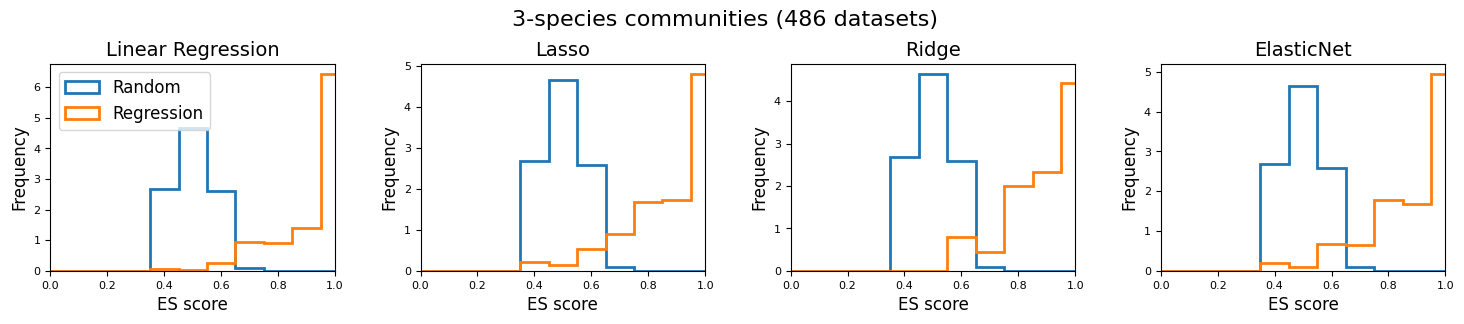

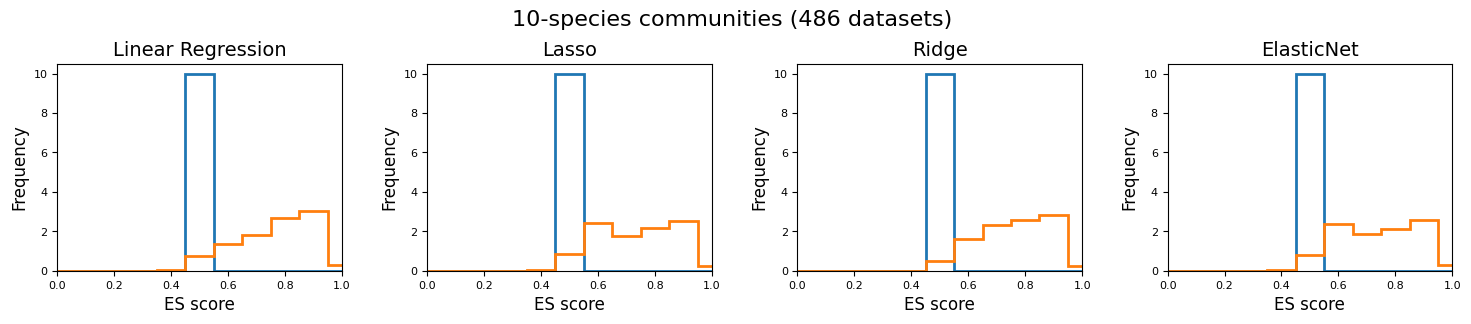

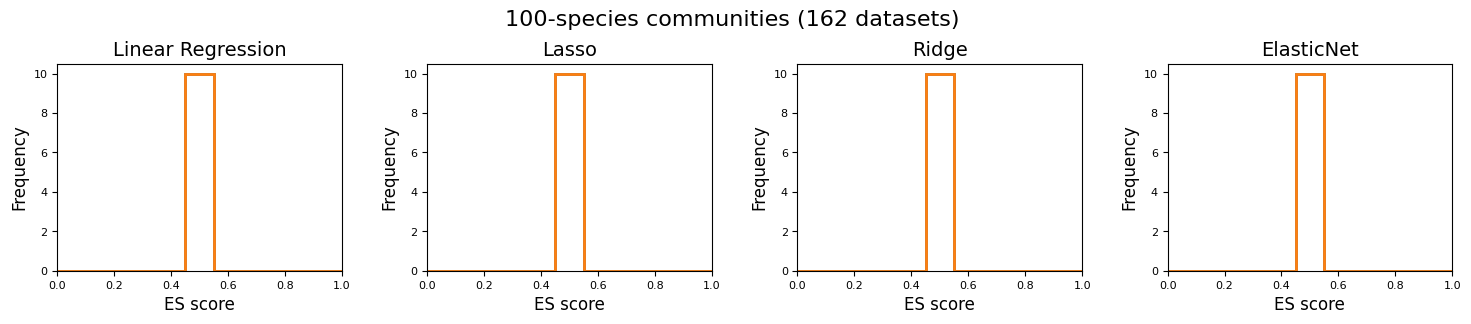

In [67]:
# plotting

bins = np.linspace(-0.05, 1.05, 12)

plt.subplots(1, 4, figsize=(18,3))
for i in range(len(geom_score_dfs)-1):
    geom_df = geom_score_dfs[i+1]
    plt.subplot(1, 4, i+1)
    if i==0:
        plt.hist(geom_random_scores[geom_random_scores.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True, label="Random")
        plt.hist(geom_df[geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True, label="Regression")
        plt.legend(loc="upper left", fontsize=12)
    else:
        plt.hist(geom_random_scores[geom_random_scores.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True)
        plt.hist(geom_df[geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i+1], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"3-species communities ({len(geom_df[geom_df.n_sp==3])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

plt.subplots(1, 4, figsize=(18,3))
for i in range(len(geom_score_dfs)-1):
    geom_df = geom_score_dfs[i+1]

    plt.subplot(1, 4, i+1)
    plt.hist(geom_random_scores[geom_random_scores.n_sp==10].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.hist(geom_df[geom_df.n_sp==10].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i+1], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"10-species communities ({len(geom_df[geom_df.n_sp==10])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

plt.subplots(1, 4, figsize=(18,3))
for i in range(len(geom_score_dfs)-1):
    geom_df = geom_score_dfs[i+1]
    plt.subplot(1, 4, i+1)
    plt.hist(geom_random_scores[geom_random_scores.n_sp==100].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.hist(geom_df[geom_df.n_sp==100].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i+1], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"100-species communities ({len(geom_df[geom_df.n_sp==100])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

In [59]:
es_score_list = [np.vstack([i[i.n_sp==j].raw.values for i in geom_score_dfs]).T for j in [3, 10, 100]]

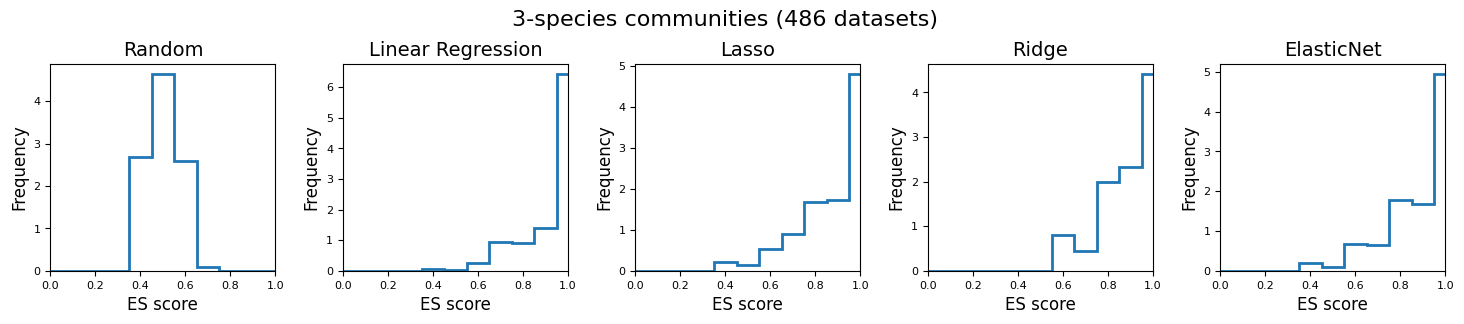

In [60]:
plt.figure(figsize=(18,3))
for i in range(es_score_list[0].shape[1]):
    plt.subplot(1, 5, i+1)
    plt.hist(es_score_list[0][:,i], bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"3-species communities ({len(geom_df[geom_df.n_sp==3])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

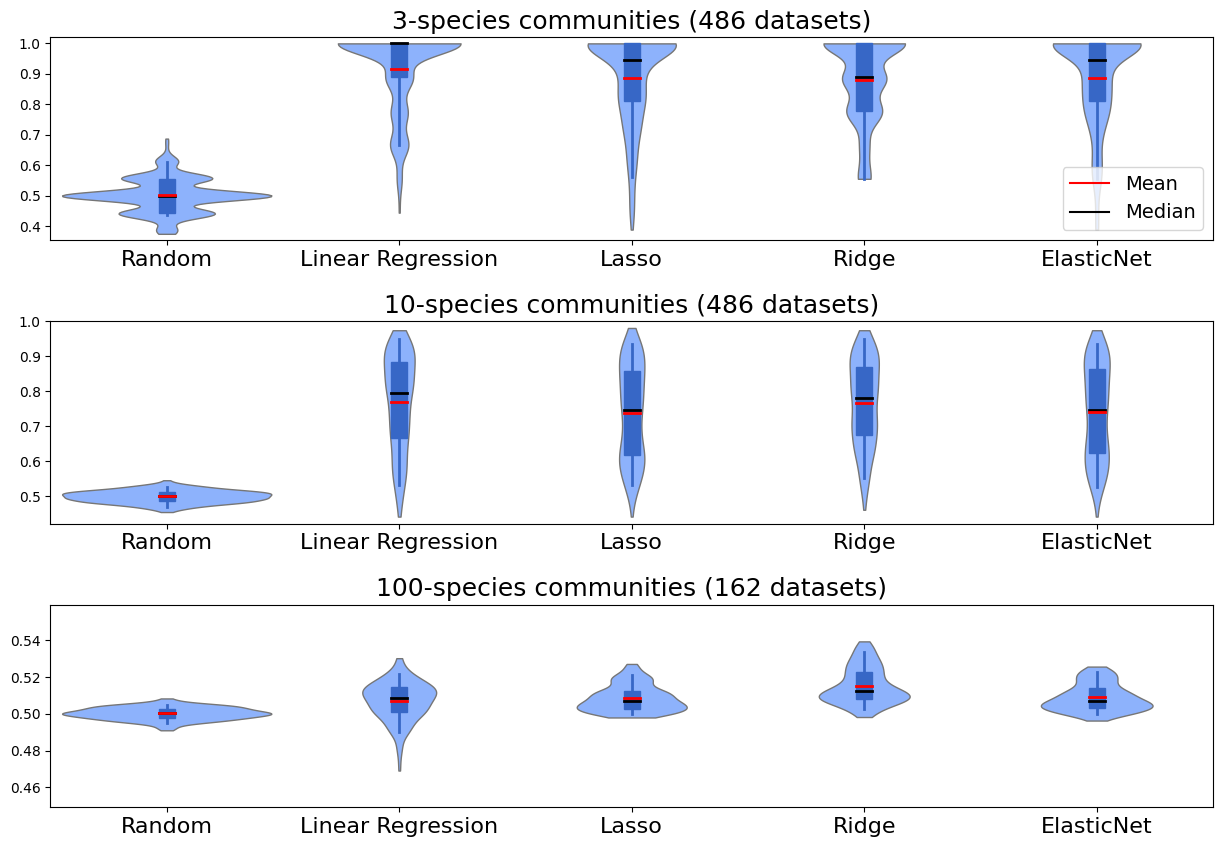

In [63]:
plt.subplots(3, 1, figsize=(15,10))
plt.subplots_adjust(hspace=0.4)
for i in range(3):
    plt.subplot(3, 1, i+1)
    sns.violinplot(pd.DataFrame(es_score_list[i], columns=reg_names), cut=0, width=0.9, saturation=1, inner=None, linewidth=1, color="#8db2fc")
    plt.boxplot(es_score_list[i], positions=np.arange(5), widths=0.07, whis=(5, 95), meanline=True, showcaps=False, showmeans=True, showfliers=False,
                medianprops=dict(color="k", lw=2), meanprops=dict(color="r", lw=2, ls="-"),
                boxprops=dict(color="#3767c6", facecolor="#3767c6"), whiskerprops=dict(color="#3767c6", lw=2), patch_artist=True)
    plt.xticks(np.arange(5), labels=reg_names, fontsize=16)
    # plt.ylim(-0.1, 1.1)
    plt.title(f"{np.unique(n_sp)[i]}-species communities ({len(es_score_list[i])} datasets)", fontsize=18)
    plt.plot(0, 0, c="r", label="Mean")
    plt.plot(0, 0, c="k", label="Median")
    plt.ylim(es_score_list[i].min()-0.02, es_score_list[i].max()+0.02)
    if i==0:
        plt.legend(loc="lower right", fontsize=14)
# plt.savefig("ES_score_violinplot.png", dpi=300, bbox_inches="tight")
plt.show()

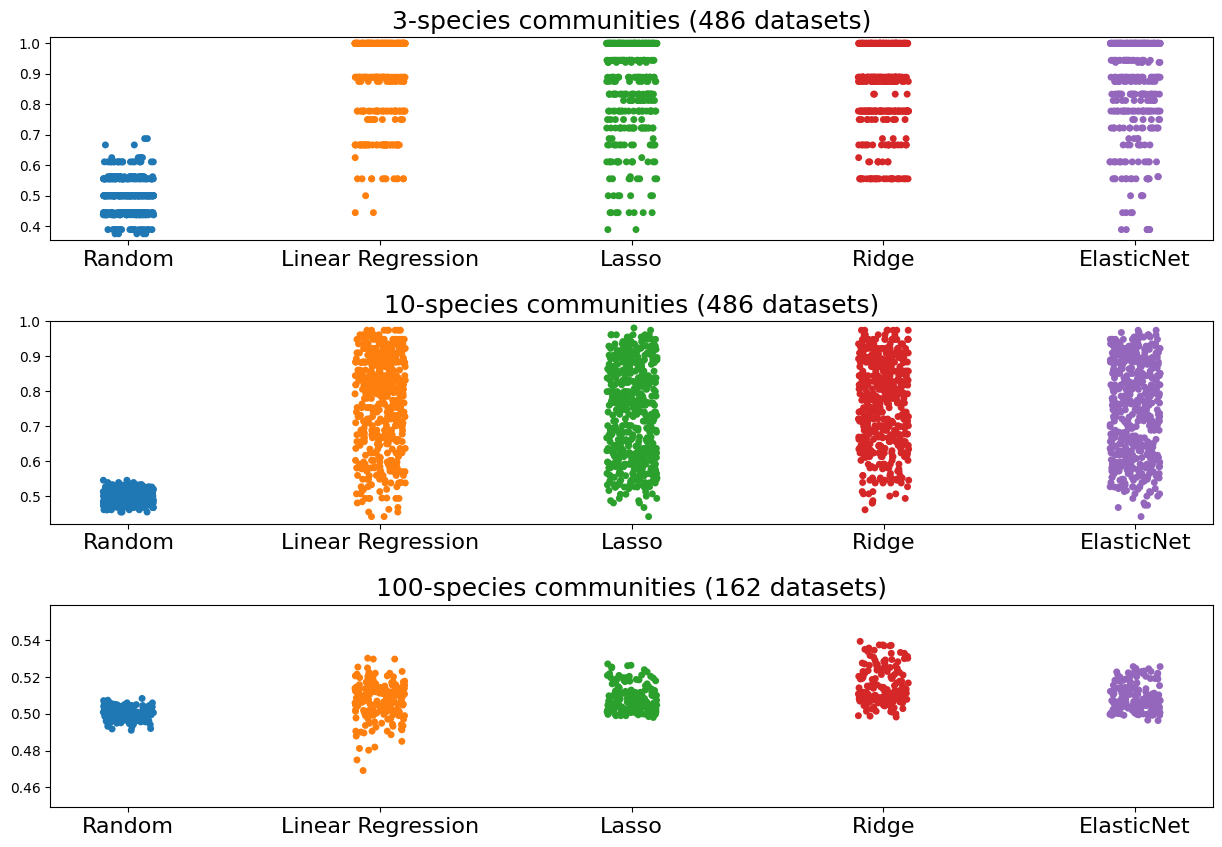

In [62]:
plt.subplots(3, 1, figsize=(15,10))
plt.subplots_adjust(hspace=0.4)
for i in range(3):
    plt.subplot(3, 1, i+1)
    sns.stripplot(pd.DataFrame(es_score_list[i], columns=reg_names))
    # sns.violinplot(pd.DataFrame(es_score_list[i], columns=reg_names), cut=0, width=0.9, saturation=1, inner=None, linewidth=1, color="#8db2fc")
    # plt.boxplot(es_score_list[i], positions=np.arange(5), widths=0.07, whis=(5, 95), meanline=True, showcaps=False, showmeans=True, showfliers=False,
    #             medianprops=dict(color="k", lw=2), meanprops=dict(color="r", lw=2, ls="-"),
    #             boxprops=dict(color="#3767c6", facecolor="#3767c6"), whiskerprops=dict(color="#3767c6", lw=2), patch_artist=True)
    plt.xticks(np.arange(5), labels=reg_names, fontsize=16)
    # plt.ylim(-0.1, 1.1)
    plt.title(f"{np.unique(n_sp)[i]}-species communities ({len(es_score_list[i])} datasets)", fontsize=18)
    plt.plot(0, 0, c="r", label="Mean")
    plt.plot(0, 0, c="k", label="Median")
    plt.ylim(es_score_list[i].min()-0.02, es_score_list[i].max()+0.02)
    # if i==0:
    #     plt.legend(loc="lower right", fontsize=14)
# plt.savefig("ES_score_violinplot.png", dpi=300, bbox_inches="tight")
plt.show()